# **Part 1**

## **Step 1**
Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

### **Data loading and initial data inspection**

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix,accuracy_score
import numpy as np


# Load the data
train_df = pd.read_csv('BBC News Train.csv')
test_df = pd.read_csv('BBC News Test.csv')

# Display the first few rows
print(train_df.head())

# Check for missing values
print(train_df.isnull().sum())

# Basic statistics: Number of articles per category
print(train_df['Category'].value_counts())
print(train_df.columns)


   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
ArticleId    0
Text         0
Category     0
dtype: int64
Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64
Index(['ArticleId', 'Text', 'Category'], dtype='object')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2998542\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2998542\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Visualization

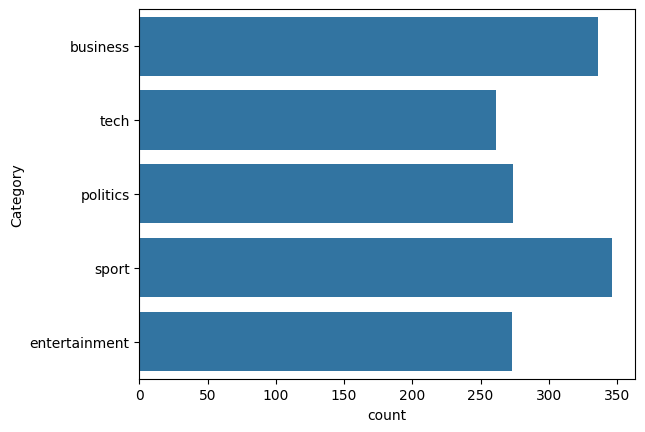

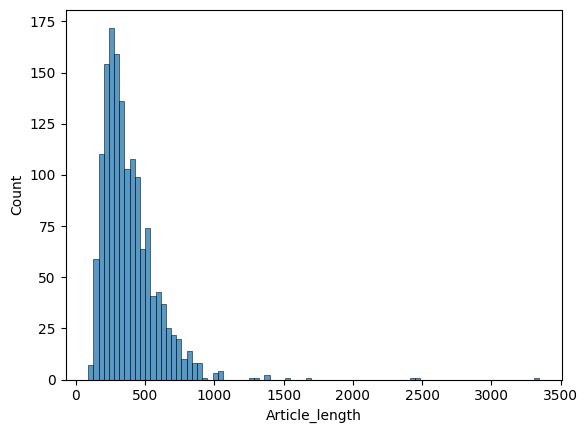

In [61]:
# Category Distribution
sns.countplot(y=train_df['Category'])
plt.show()

# Article Length Distribution
train_df['Article_length'] = train_df['Text'].apply(lambda x: len(x.split()))
sns.histplot(train_df['Article_length'])
plt.show()


### Data Cleaning

In [62]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize, convert words to their root form. For instance, "running" becomes "run".
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

train_df['Cleaned_Article'] = train_df['Text'].apply(preprocess_text)
print(train_df['Cleaned_Article'].head())

# Preprocessing for test dataset
test_df['Cleaned_Text'] = test_df['Text'].apply(preprocess_text)


0    worldcom exboss launch defence lawyer defendin...
1    german business confidence slide german busine...
2    bbc poll indicates economic gloom citizen majo...
3    lifestyle governs mobile choice faster better ...
4    enron boss payout eighteen former enron direct...
Name: Cleaned_Article, dtype: object


### Word Embedding
For this problem we will use TF-IDF (Term Frequency-Inverse Document Frequency).

- TF (Term Frequency): It measures how frequently a term occurs in a document.

- IDF (Inverse Document Frequency): It measures how important a term is. While computing TF, all terms are considered equally important. However, certain terms, such as "is" or "and", may appear many times but have little importance. Thus we need to weigh down the frequent terms while scaling up the rare ones.


In [63]:
vectorizer = TfidfVectorizer(max_features=5000) # Limit to top 5000 words for simplicity
X_train = vectorizer.fit_transform(train_df['Cleaned_Article'])

### Word Statistic and visualizations

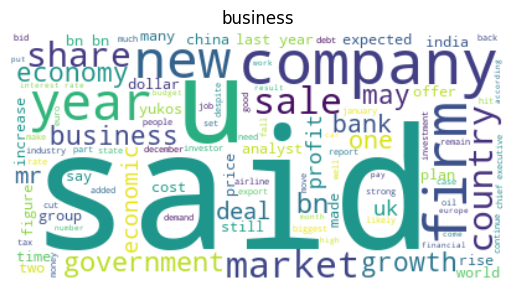

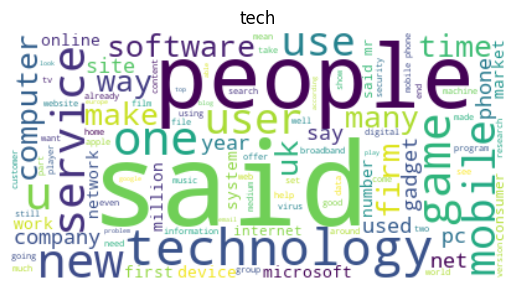

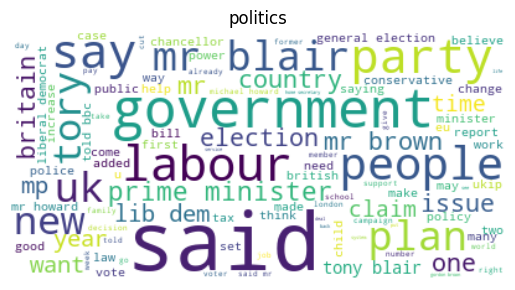

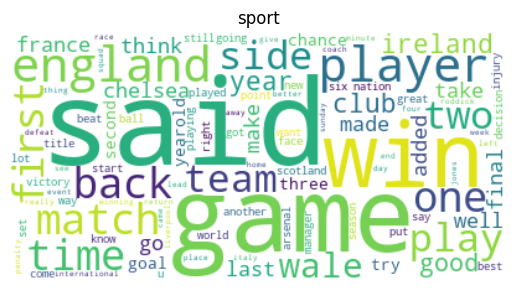

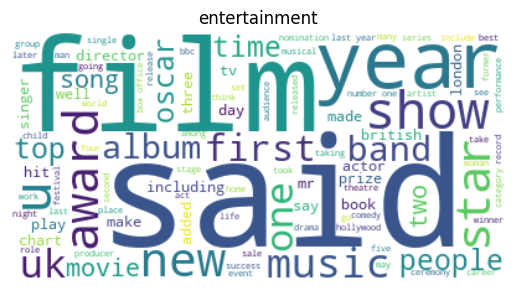

In [64]:
# Generate word cloud for each category
categories = train_df['Category'].unique()
for category in categories:
    subset = train_df[train_df['Category'] == category]
    text = ' '.join(subset['Cleaned_Article'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(category)
    plt.axis('off')
    plt.show()


## **Step 2**

### Matrix Factorization Model

In [65]:
n_topics = 5  # There are 5 categories in the dataset; can be adjusted
nmf = NMF(n_components=n_topics, random_state=42)
W_train = nmf.fit_transform(X_train)
H = nmf.components_

### Predictions and performance metrics

{'business': 0, 'tech': 1, 'politics': 2, 'sport': 3, 'entertainment': 4}
Training Accuracy: 0.2395973154362416


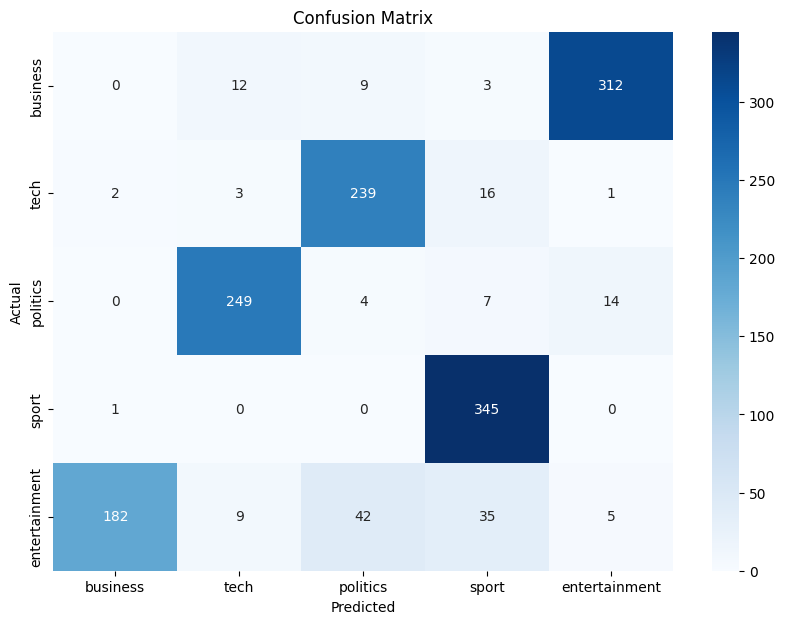

In [66]:


# Create label mapping
unique_categories = train_df['Category'].unique()
label_mapping = {category: index for index, category in enumerate(unique_categories)}
print(label_mapping)

# Get dominant topic for each document
train_predictions = np.argmax(W_train, axis=1)

# For test data
X_test = vectorizer.transform(test_df['Cleaned_Text'])
W_test = nmf.transform(X_test)
test_predictions = np.argmax(W_test, axis=1)


train_accuracy = accuracy_score(train_df['Category'].map(label_mapping), train_predictions)
print("Training Accuracy:", train_accuracy)

##For confusion matrix


# Get the numeric labels for the 'Category' column
true_labels = train_df['Category'].map(label_mapping)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, train_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Maximizing the training accuracy

In [67]:
# Defining search space for hyperparameters
n_topics_range = [3, 5, 7, 10]  # The number of topics/components
max_features_range = [2000, 3000, 5000, 7000]  # Number of words to consider based on TF-IDF score

best_accuracy = 0
best_params = None

for n_topics in n_topics_range:
    for max_features in max_features_range:
        
        # Word embedding
        vectorizer = TfidfVectorizer(max_features=max_features)
        X_train = vectorizer.fit_transform(train_df['Cleaned_Article'])
        
        # Matrix Factorization using NMF
        nmf = NMF(n_components=n_topics, random_state=42)
        W_train = nmf.fit_transform(X_train)
        
        # Predictions
        train_predictions = np.argmax(W_train, axis=1)
        
        # Evaluation
        accuracy = accuracy_score(true_labels, train_predictions)
        
        print(f'n_topics: {n_topics}, max_features: {max_features}, Training Accuracy: {accuracy}')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_topics': n_topics, 'max_features': max_features}

print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_accuracy}")


n_topics: 3, max_features: 2000, Training Accuracy: 0.04563758389261745
n_topics: 3, max_features: 3000, Training Accuracy: 0.39865771812080536
n_topics: 3, max_features: 5000, Training Accuracy: 0.015436241610738255
n_topics: 3, max_features: 7000, Training Accuracy: 0.2040268456375839
n_topics: 5, max_features: 2000, Training Accuracy: 0.04899328859060403
n_topics: 5, max_features: 3000, Training Accuracy: 0.6382550335570469
n_topics: 5, max_features: 5000, Training Accuracy: 0.2395973154362416
n_topics: 5, max_features: 7000, Training Accuracy: 0.24295302013422818
n_topics: 7, max_features: 2000, Training Accuracy: 0.038926174496644296
n_topics: 7, max_features: 3000, Training Accuracy: 0.5919463087248322
n_topics: 7, max_features: 5000, Training Accuracy: 0.23557046979865773
n_topics: 7, max_features: 7000, Training Accuracy: 0.22617449664429531
n_topics: 10, max_features: 2000, Training Accuracy: 0.016778523489932886
n_topics: 10, max_features: 3000, Training Accuracy: 0.293288590

In [76]:
print(test_df.columns)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline

# Use TF-IDF to vectorize the text data
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(train_df['Cleaned_Article'])
X_test_tfidf = vectorizer.transform(test_df['Cleaned_Text'])  # Assuming you've cleaned the test data in a similar way to training data

# Train a Linear SVM classifier
clf = LinearSVC()
clf.fit(X_train_tfidf, train_df['Category'])

# Make predictions on the test data
y_pred = clf.predict(X_test_tfidf)

# Evaluate the performance
accuracy = accuracy_score(test_df['Category'], y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(classification_report(test_df['Category'], y_pred))



Index(['ArticleId', 'Text', 'Cleaned_Text'], dtype='object')
Test Accuracy: 100.00%


C:\Users\2998542\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
